# Exploratory Data Analysis

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
import os

os.chdir("..")


In [2]:
# Read in datasets
members_df = pd.read_csv("artifacts/members_v3.csv")
transactions_df = pd.read_csv("artifacts/transactions_v2.csv")
user_logs_df = pd.read_csv("artifacts/user_logs_v2.csv")
train_df = pd.read_csv("artifacts/train_v2.csv")

# Train set EDA

In [5]:
train_df.head()

,msno,is_churn
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970960 entries, 0 to 970959
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   msno      970960 non-null  object
 1   is_churn  970960 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 14.8+ MB


No null data

Checking Proportion of churn:

In [7]:
train_df["is_churn"].value_counts()

is_churn
0    883630
1     87330
Name: count, dtype: int64

Proportion of churn indicates dataset is unbalanced. Will require stratified splitting during train test splits.

# Member set EDA

In [8]:
members_df.head()

,msno,city,bd,gender,registered_via,registration_init_time
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,NaN,11,20110911
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,20110914
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,NaN,11,20110915
3,9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,1,0,NaN,11,20110915
4,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,female,9,20110915


In [58]:
members_df_churn = pd.merge(members_df, train_df, on="msno", how='inner')
members_df_churn.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860967 entries, 0 to 860966
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   msno                    860967 non-null  object
 1   city                    860967 non-null  int64 
 2   bd                      860967 non-null  int64 
 3   gender                  388905 non-null  object
 4   registered_via          860967 non-null  int64 
 5   registration_init_time  860967 non-null  int64 
 6   is_churn                860967 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 46.0+ MB


Lots of null values for gender feature. Will drop.

#### Checking frequency of all member features

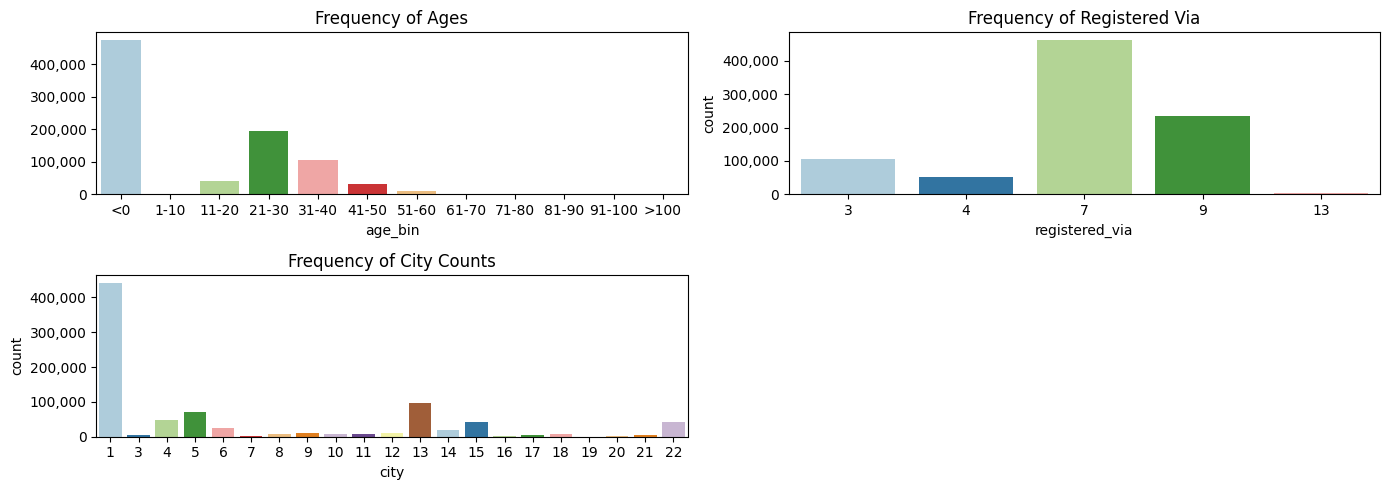

In [6]:
plt.figure(figsize=(14,5))

# Format y-axis tick labels
def format_ticks(x, pos):
    return '{:,.0f}'.format(x)


# Proportion of age ("bd")

ax1 = plt.subplot(2, 2, 1)
bins = [-float('inf'), 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, float('inf')]
bin_labels = ['<0', '1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', '>100']

members_df_churn['age_bin'] = pd.cut(members_df_churn['bd'], bins=bins, labels=bin_labels)

age_counts = members_df_churn['age_bin'].value_counts().sort_index()

sns.barplot(x=age_counts.index, y=age_counts.values, ax=ax1, palette='Paired', hue=age_counts.index, legend=False)

# Apply the formatter to the y-axis ticks
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax1.set_title('Frequency of Ages')



ax2 = plt.subplot(2, 2, 2)
sns.barplot(data = members_df_churn["registered_via"].value_counts().reset_index(), x="registered_via", y= "count", ax=ax2, hue="registered_via", palette="Paired", legend=False)
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax2.set_title('Frequency of Registered Via')

ax3 = plt.subplot(2, 2, 3)
sns.barplot(data = members_df_churn["city"].value_counts().reset_index(), x="city", y= "count", ax=ax3, hue="city", palette="Paired", legend=False)
ax3.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax3.set_title('Frequency of City Counts')


plt.tight_layout()
plt.show()


<b>Key points:</b>
- Age has a lot of outliers (<0 ages), so will most likely drop
- Most users registered via 7, followed by 9, 3, 4 and 13.
- Most users are from city 1

#### Looking at member registration dates

In [59]:
# Changing to date format
members_df_date = members_df_churn.copy()
members_df_date['registration_init_time'] = pd.to_datetime(members_df_date['registration_init_time'], format='%Y%m%d')

# Set the date as the index
members_df_date.set_index('registration_init_time', inplace=True)

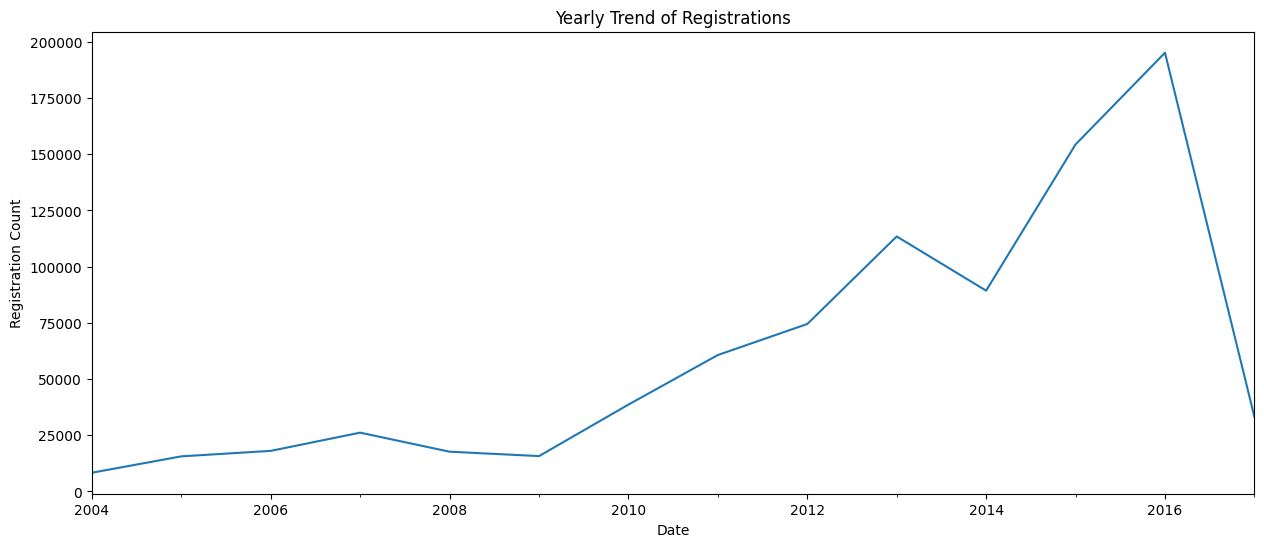

In [14]:
# Resample to get the count per day
daily_counts = members_df_date.resample('YE').size()

# Plot the time series line plot
plt.figure(figsize=(15, 6))
daily_counts.plot()
plt.title('Yearly Trend of Registrations')
plt.xlabel('Date')
plt.ylabel('Registration Count')
plt.show()

Key points:
- Registration counts saw a decline in 2014. However from 2015 to 2016, we see a spike in registrations. *Reduction of registrations from 2016 onwards is due to lack of data.

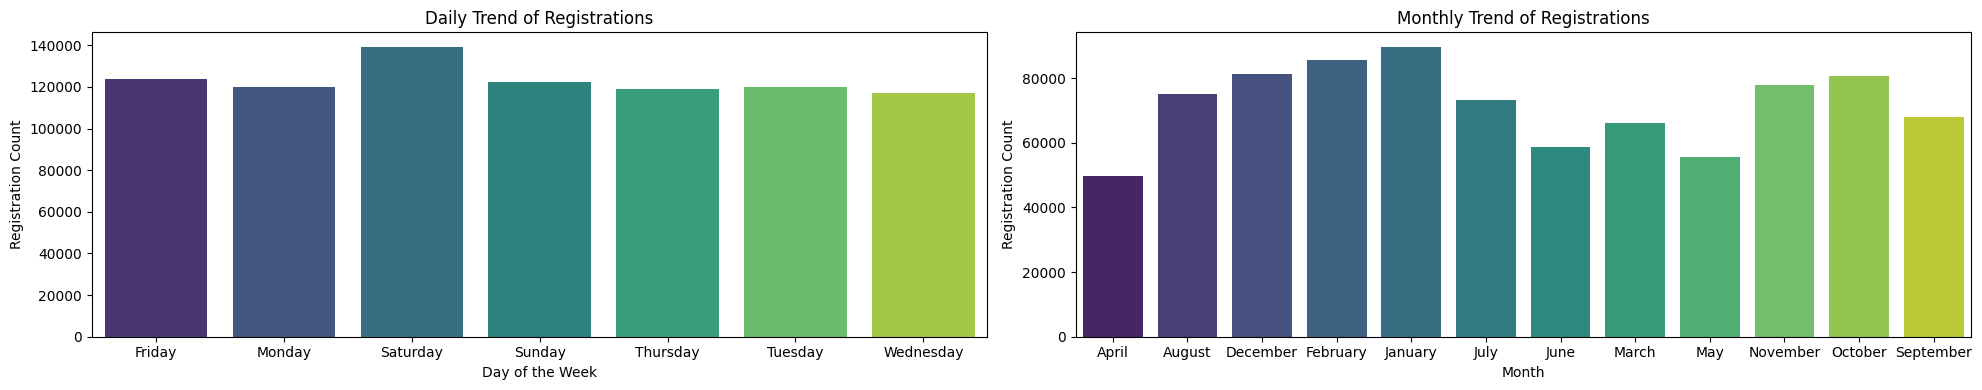

In [12]:
plt.figure(figsize=(20,4))

# Counts of registrations by day of the week
members_df_date['day_of_week'] = members_df_date.index.day_name()
day_counts = members_df_date['day_of_week'].value_counts().sort_index()

ax1 = plt.subplot(1,2,1)
sns.barplot(x=day_counts.index, y=day_counts.values, palette='viridis', hue =day_counts.index, ax=ax1)
plt.title('Daily Trend of Registrations')
plt.xlabel('Day of the Week')
plt.ylabel('Registration Count')


# Counts of registrations by day of the month
members_df_date['month'] = members_df_date.index.month_name()
month_counts = members_df_date['month'].value_counts().sort_index()

ax2 = plt.subplot(1,2,2)
sns.barplot(x=month_counts.index, y=month_counts.values, palette='viridis', hue =month_counts.index, ax=ax2)
plt.title('Monthly Trend of Registrations')
plt.xlabel('Month')
plt.ylabel('Registration Count')

plt.tight_layout()
plt.show()


Key points:
- Most users registered on Saturday compared to other days
- January saw the most registations followed by February and December

#### Proportion of churn with registration method and city:

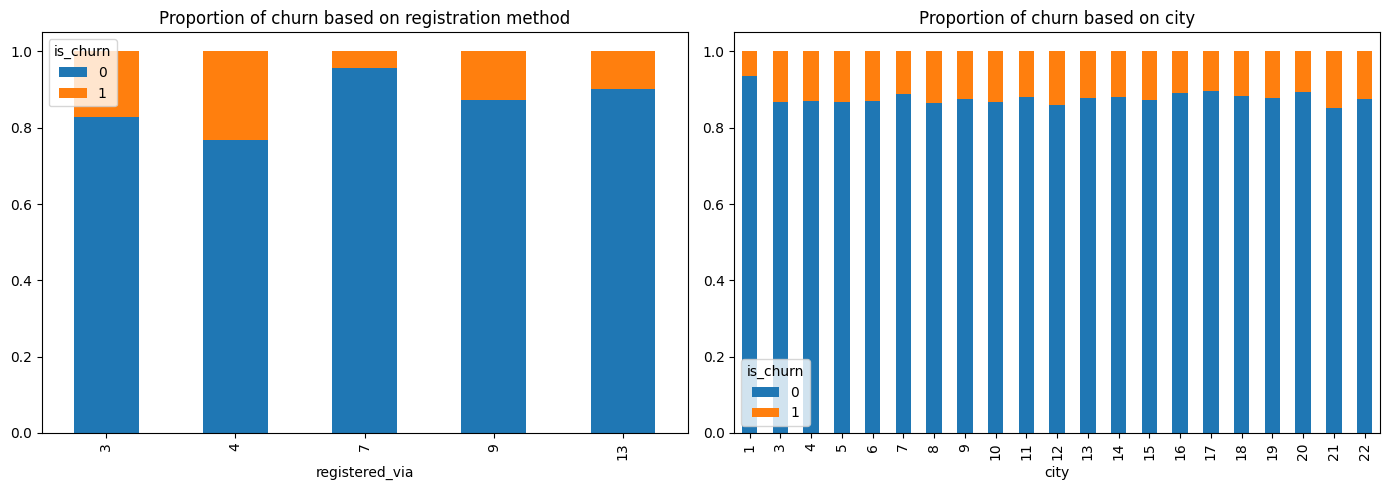

In [77]:
plt.figure(figsize=(14,5))

ax1 = plt.subplot(1,2,1)
ax1.title.set_text('Proportion of churn based on registration method')
churn_proportions_register = members_df_churn.groupby('registered_via')['is_churn'].value_counts(normalize=True).unstack()
churn_proportions_register.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'], ax=ax1)

ax2 = plt.subplot(1,2,2)
ax2.title.set_text('Proportion of churn based on city')
churn_proportions_city = members_df_churn.groupby('city')['is_churn'].value_counts(normalize=True).unstack()
churn_proportions_city.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'], ax=ax2)

plt.tight_layout()
plt.show()

<b>Observations:</b>
- A higher proportion of users who registered via 4 churned, while those who registered with 7 churned at a lower rate.
- Users from city one churned at a lower rate compared to other cities 


# Transaction set EDA

In [3]:
transactions_df.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,32,90,298,298,0,20170131,20170504,0
1,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,20150809,20190412,0
2,+/GXNtXWQVfKrEDqYAzcSw2xSPYMKWNj22m+5XkVQZc=,36,30,180,180,1,20170303,20170422,0
3,+/w1UrZwyka4C9oNH3+Q8fUf3fD8R3EwWrx57ODIsqk=,36,30,180,180,1,20170329,20170331,1
4,+00PGzKTYqtnb65mPKPyeHXcZEwqiEzktpQksaaSC3c=,41,30,99,99,1,20170323,20170423,0


In [4]:
transactions_df_churn = pd.merge(transactions_df, train_df, on="msno", how='inner')
transactions_df_churn.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132036 entries, 0 to 1132035
Data columns (total 10 columns):
 #   Column                  Non-Null Count    Dtype 
---  ------                  --------------    ----- 
 0   msno                    1132036 non-null  object
 1   payment_method_id       1132036 non-null  int64 
 2   payment_plan_days       1132036 non-null  int64 
 3   plan_list_price         1132036 non-null  int64 
 4   actual_amount_paid      1132036 non-null  int64 
 5   is_auto_renew           1132036 non-null  int64 
 6   transaction_date        1132036 non-null  int64 
 7   membership_expire_date  1132036 non-null  int64 
 8   is_cancel               1132036 non-null  int64 
 9   is_churn                1132036 non-null  int64 
dtypes: int64(9), object(1)
memory usage: 86.4+ MB


#### Plotting frequency of transaction categorical features:

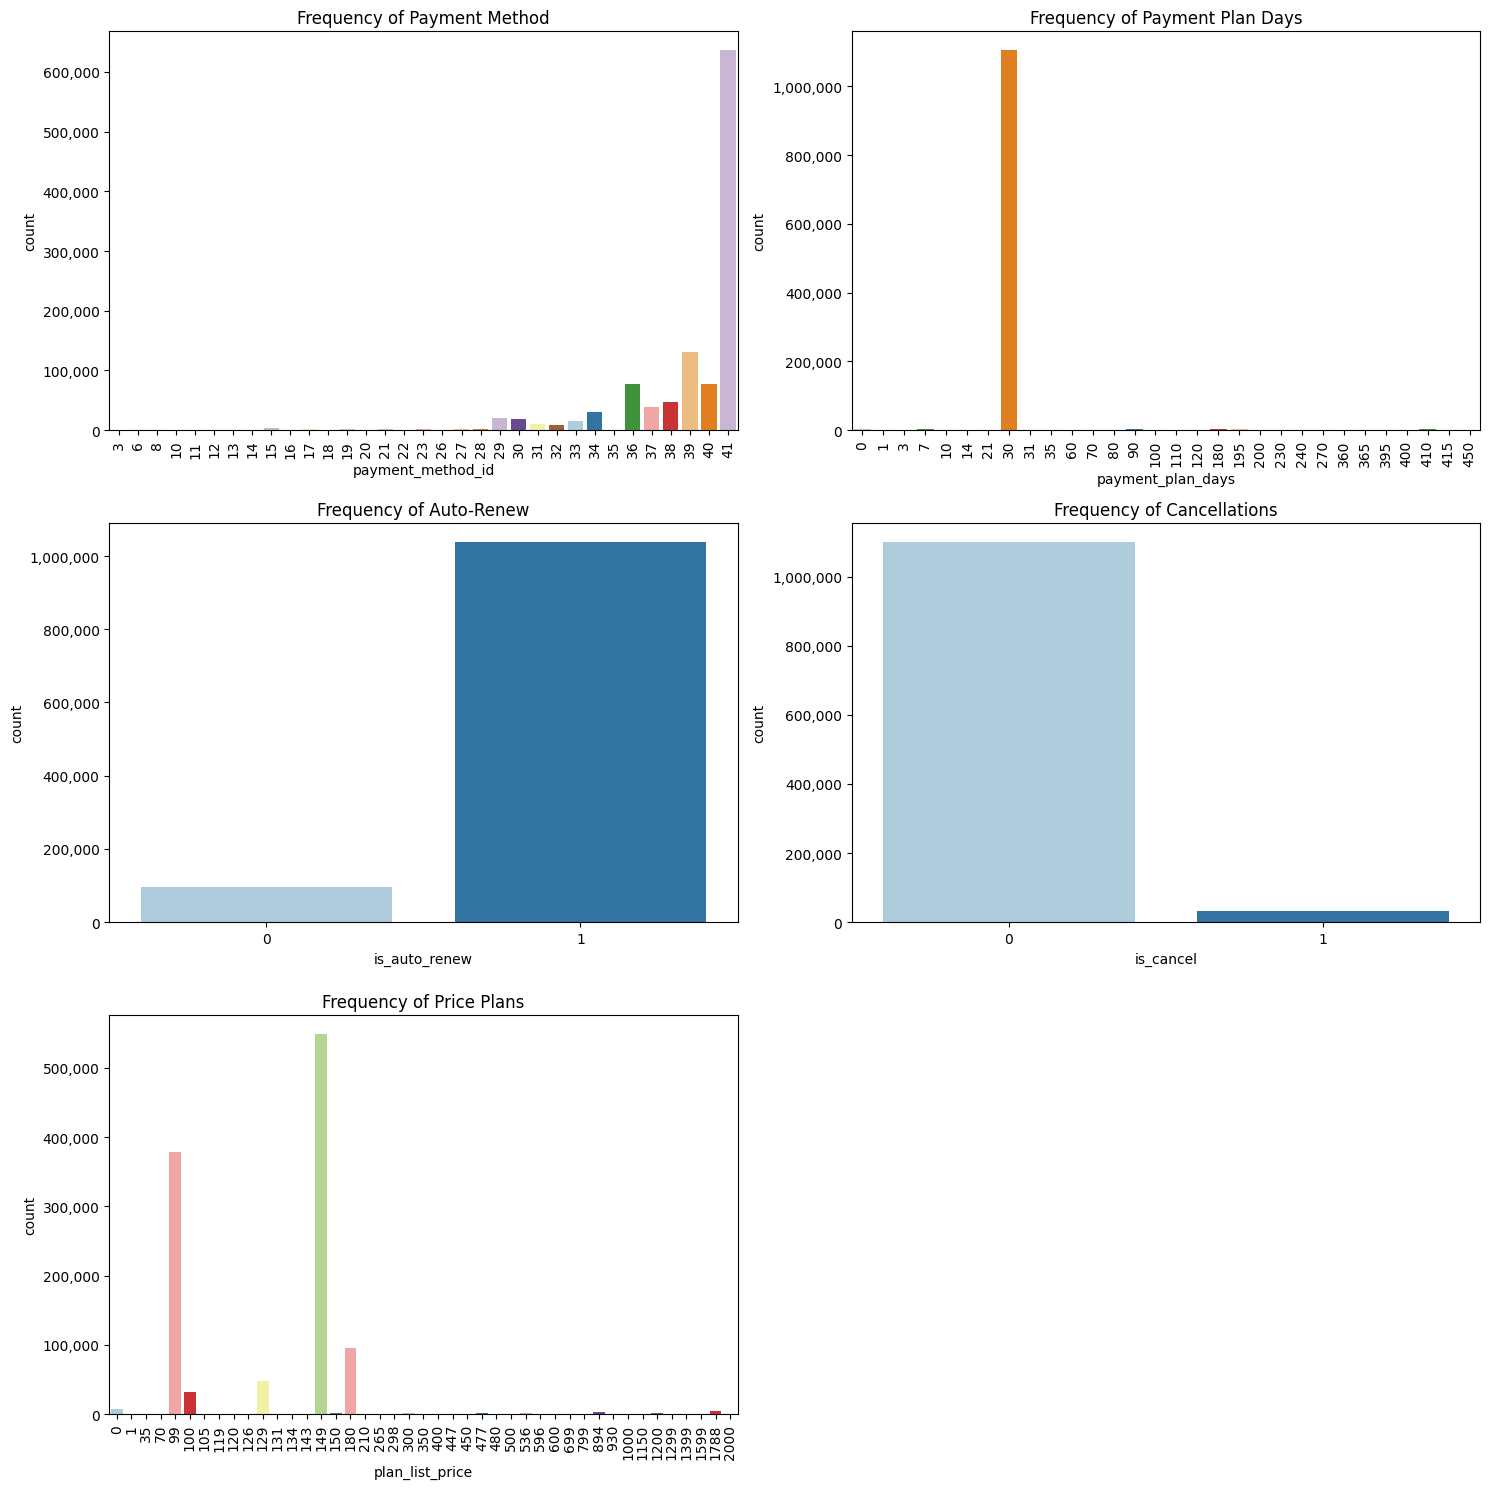

In [34]:
plt.figure(figsize=(15,15))

# Format y-axis tick labels
def format_ticks(x, pos):
    return '{:,.0f}'.format(x)


ax1 = plt.subplot(3, 2, 1)
sns.barplot(data = transactions_df_churn["payment_method_id"].value_counts().reset_index(), x="payment_method_id", y= "count", ax=ax1, hue="payment_method_id", palette="Paired", legend=False)
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax1.set_title('Frequency of Payment Method')
plt.xticks(rotation=90) 


ax2 = plt.subplot(3, 2, 2)
sns.barplot(data = transactions_df_churn["payment_plan_days"].value_counts().reset_index(), x="payment_plan_days", y= "count", ax=ax2, hue="payment_plan_days", palette="Paired", legend=False)
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax2.set_title('Frequency of Payment Plan Days')
plt.xticks(rotation=90) 


ax3 = plt.subplot(3, 2, 3)
sns.barplot(data = transactions_df_churn["is_auto_renew"].value_counts().reset_index(), x="is_auto_renew", y= "count", ax=ax3, hue="is_auto_renew", palette="Paired", legend=False)
ax3.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax3.set_title('Frequency of Auto-Renew')



ax4 = plt.subplot(3, 2, 4)
sns.barplot(data = transactions_df_churn["is_cancel"].value_counts().reset_index(), x="is_cancel", y= "count", ax=ax4, hue="is_cancel", palette="Paired", legend=False)
ax4.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax4.set_title('Frequency of Cancellations')



ax5 = plt.subplot(3, 2, 5)
sns.barplot(data = transactions_df_churn["plan_list_price"].value_counts().reset_index(), x="plan_list_price", y= "count", ax=ax5, hue="plan_list_price", palette="Paired", legend=False)
ax5.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax5.set_title('Frequency of Price Plans')
plt.xticks(rotation=90) 


plt.tight_layout()
plt.show()

<b>Key Observations:</b>
- Most users paid using payment method '41'
- Majority of users picked the 30 day plan
- Majority of users auto renewed their payments/subscriptions
- Majority of users did not cancel their subscriptions
- Most users subscribed with the 149 and 99 prices

### Proportion of users who recieved a discount:

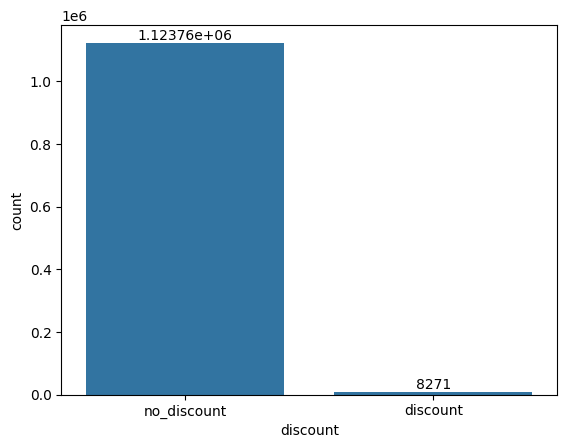

In [14]:
transactions_df_churn["discount"] = transactions_df_churn['actual_amount_paid'] < transactions_df_churn["plan_list_price"]


ax = sns.barplot(transactions_df_churn["discount"].value_counts().rename({True: 'discount', False: 'no_discount'}))
for i in ax.containers:
    ax.bar_label(i,)

<b>Key Observations:</b>
- Majority of users paid full price and did not recieve a discount

### Proportion of churn vs transaction variables

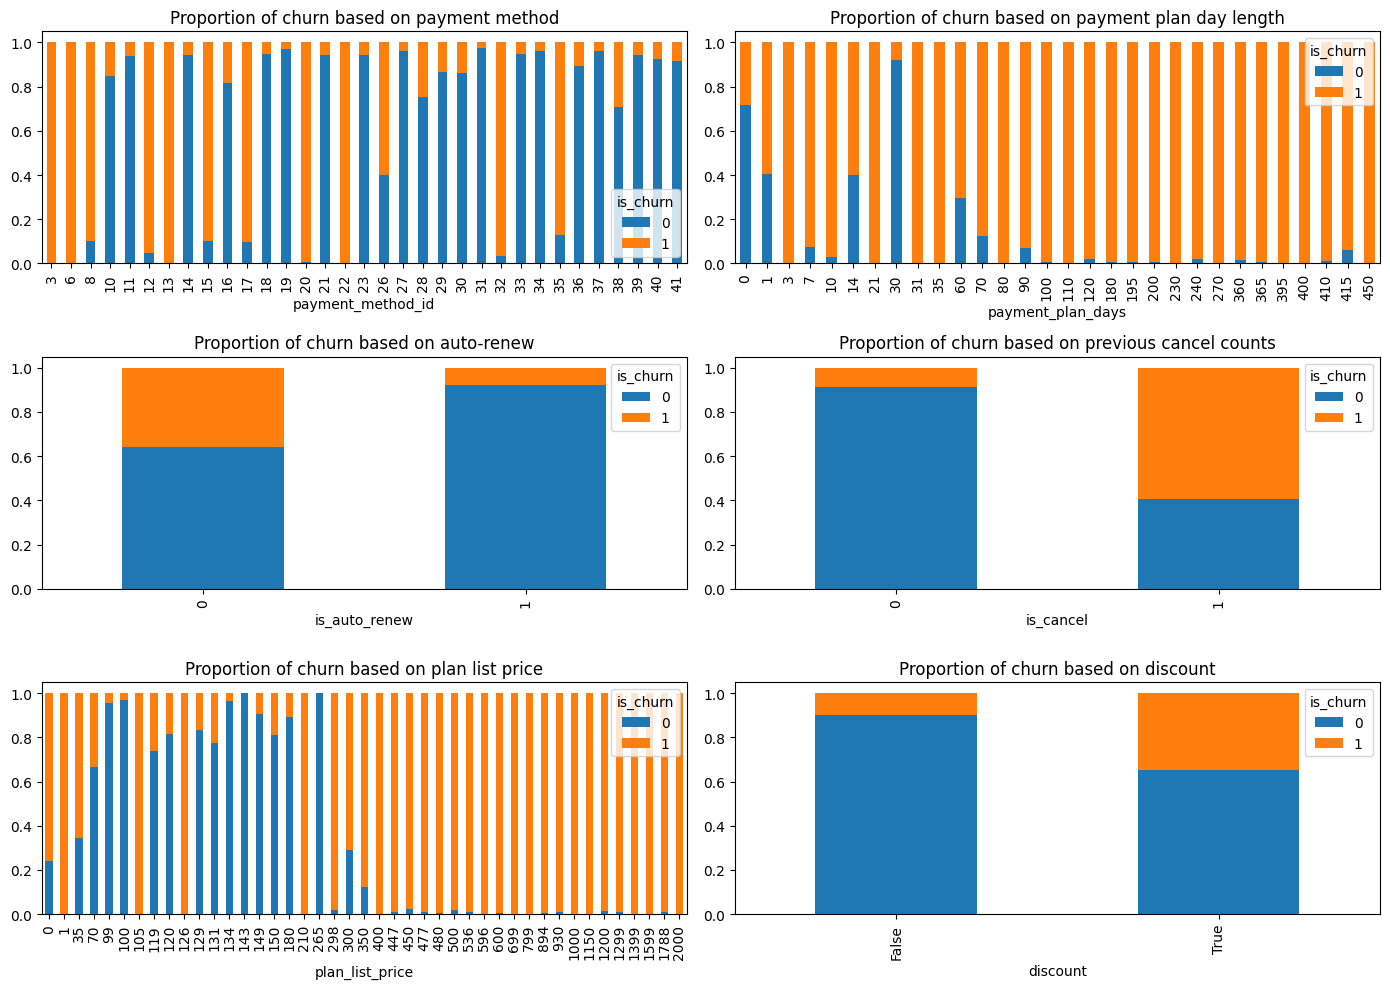

In [16]:
plt.figure(figsize=(14,10))

ax1 = plt.subplot(3,2,1)
ax1.title.set_text('Proportion of churn based on payment method')
churn_proportions_register = transactions_df_churn.groupby('payment_method_id')['is_churn'].value_counts(normalize=True).unstack()
churn_proportions_register.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'], ax=ax1)

ax2 = plt.subplot(3,2,2)
ax2.title.set_text('Proportion of churn based on payment plan day length')
churn_proportions_city = transactions_df_churn.groupby('payment_plan_days')['is_churn'].value_counts(normalize=True).unstack()
churn_proportions_city.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'], ax=ax2)

ax3 = plt.subplot(3,2,3)
ax3.title.set_text('Proportion of churn based on auto-renew')
churn_proportions_city = transactions_df_churn.groupby('is_auto_renew')['is_churn'].value_counts(normalize=True).unstack()
churn_proportions_city.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'], ax=ax3)

ax4 = plt.subplot(3,2,4)
ax4.title.set_text('Proportion of churn based on previous cancel counts')
churn_proportions_city = transactions_df_churn.groupby('is_cancel')['is_churn'].value_counts(normalize=True).unstack()
churn_proportions_city.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'], ax=ax4)

ax5 = plt.subplot(3,2,5)
ax5.title.set_text('Proportion of churn based on plan list price')
churn_proportions_city = transactions_df_churn.groupby('plan_list_price')['is_churn'].value_counts(normalize=True).unstack()
churn_proportions_city.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'], ax=ax5)

ax6 = plt.subplot(3,2,6)
ax6.title.set_text('Proportion of churn based on discount')
churn_proportions_city = transactions_df_churn.groupby('discount')['is_churn'].value_counts(normalize=True).unstack()
churn_proportions_city.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'], ax=ax6)


plt.tight_layout()
plt.show()

<b>Key Observations:</b>
- Majority of users who selected payment plans with 30 days did not churn
- A higher amount of users who had auto renew did not churn compared to those who did not auto-renew their subscription
- Users who cancelled their subsciptions in the past had a higher proportion of churning
- Users who recieved discounts had a higher proportion of churning compared to users who did not.

# User Logs set EDA

In [17]:
user_logs_df.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,u9E91QDTvHLq6NXjEaWv8u4QIqhrHk72kE+w31Gnhdg=,20170331,8,4,0,1,21,18,6309.273
1,nTeWW/eOZA/UHKdD5L7DEqKKFTjaAj3ALLPoAWsU8n0=,20170330,2,2,1,0,9,11,2390.699
2,2UqkWXwZbIjs03dHLU9KHJNNEvEkZVzm69f3jCS+uLI=,20170331,52,3,5,3,84,110,23203.337
3,ycwLc+m2O0a85jSLALtr941AaZt9ai8Qwlg9n0Nql5U=,20170331,176,4,2,2,19,191,7100.454
4,EGcbTofOSOkMmQyN1NMLxHEXJ1yV3t/JdhGwQ9wXjnI=,20170331,2,1,0,1,112,93,28401.558


In [18]:
user_logs_df_churn = pd.merge(user_logs_df, train_df, on="msno", how='inner')
user_logs_df_churn.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13532944 entries, 0 to 13532943
Data columns (total 10 columns):
 #   Column      Non-Null Count     Dtype  
---  ------      --------------     -----  
 0   msno        13532944 non-null  object 
 1   date        13532944 non-null  int64  
 2   num_25      13532944 non-null  int64  
 3   num_50      13532944 non-null  int64  
 4   num_75      13532944 non-null  int64  
 5   num_985     13532944 non-null  int64  
 6   num_100     13532944 non-null  int64  
 7   num_unq     13532944 non-null  int64  
 8   total_secs  13532944 non-null  float64
 9   is_churn    13532944 non-null  int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 1.0+ GB


In [32]:
user_logs_df_churn.describe()

,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,is_churn
count,1.353294e+07,1.353294e+07,1.353294e+07,1.353294e+07,1.353294e+07,1.353294e+07,1.353294e+07,1.353294e+07,1.353294e+07
mean,2.017032e+07,6.064857e+00,1.464016e+00,9.225333e-01,1.043397e+00,2.988009e+01,2.854063e+01,7.793904e+03,7.954500e-02
std,8.927878e+00,1.324969e+01,3.724314e+00,1.858066e+00,2.807856e+00,4.023682e+01,3.176500e+01,9.722439e+03,2.705875e-01
min,2.017030e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e-03,0.000000e+00
25%,2.017031e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00,8.000000e+00,1.941920e+03,0.000000e+00
50%,2.017032e+07,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.600000e+01,1.800000e+01,4.514544e+03,0.000000e+00
75%,2.017032e+07,7.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,3.600000e+01,3.700000e+01,9.693216e+03,0.000000e+00
max,2.017033e+07,5.213000e+03,8.310000e+02,3.780000e+02,1.010000e+03,9.838000e+03,4.925000e+03,2.307918e+06,1.000000e+00


In [35]:
max(user_logs_df_churn["num_25"])

5213